In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Import RobustScaler as we discussed
from sklearn.preprocessing import RobustScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load your datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Data loaded successfully!")

    # --- NEW: Slicing the data as requested ---
    
    # 1. Slice the test_ids to match the 200 rows
    test_ids = test_df['Id'].iloc[:200]
    
    # 2. Drop the 'Id' column from both
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    # 3. Select the first 35 feature columns
    feature_cols = list(train_df.columns[:35])
    
    # 4. Add 'SalePrice' for the training set
    train_cols = feature_cols + ['SalePrice']
    
    # 5. Slice train_df to 200 rows and the selected columns
    train_df = train_df[train_cols].iloc[:200]
    
    # 6. Slice test_df to 200 rows and the same 35 feature columns
    test_df = test_df[feature_cols].iloc[:200]
    
    print(f"Data sliced: Training data shape: {train_df.shape}")
    print(f"Data sliced: Test data shape: {test_df.shape}")
    # --- End of slicing ---

except FileNotFoundError:
    print("Error: train.csv or test.csv not found. Check your file paths.")

Data loaded successfully!
Data sliced: Training data shape: (200, 36)
Data sliced: Test data shape: (200, 35)


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. LOAD FULL DATA ---
print("Loading full dataset...")
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    
    # Keep IDs for submission
    train_ids = train_df['Id']
    test_ids = test_df['Id']
    
    # Drop Id
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)
except FileNotFoundError:
    print("Error: train.csv or test.csv not found.")
    # Stop execution if files aren't found
    raise

# --- 2. ADVANCED FEATURE ENGINEERING ---

# A. Transform the target variable (SalePrice)
# This is the single most important step for this problem
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# B. Handle Skewed Numeric Features
# Log transform numeric features that are highly skewed
skewed_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']
for col in skewed_features:
    # Use SimpleImputer for LotFrontage before log transform
    if col == 'LotFrontage':
        train_df[col] = train_df[col].fillna(train_df.groupby('Neighborhood')[col].transform('median'))
        test_df[col] = test_df[col].fillna(test_df.groupby('Neighborhood')[col].transform('median'))
        # If still missing, fill with 0
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)
    
    # Fill other NaNs with 0 before log
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)
    
    # Apply log1p transform
    train_df[col] = np.log1p(train_df[col])
    test_df[col] = np.log1p(test_df[col])

# C. Define feature lists (Numeric, Ordinal, One-Hot)
# Some features that look numeric are actually categories
train_df['MSSubClass'] = train_df['MSSubClass'].astype(str)
test_df['MSSubClass'] = test_df['MSSubClass'].astype(str)
train_df['YrSold'] = train_df['YrSold'].astype(str)
test_df['YrSold'] = test_df['YrSold'].astype(str)
train_df['MoSold'] = train_df['MoSold'].astype(str)
test_df['MoSold'] = test_df['MoSold'].astype(str)

# Manually define ordinal (ranked) features and their orders
# This is key to getting a good score
ordinal_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]
quality_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
qual_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

# Fill NA with 'NA' string before mapping
for col in ordinal_cols:
    train_df[col] = train_df[col].fillna('NA')
    test_df[col] = test_df[col].fillna('NA')
    # Handle 'None' in test set if it appears
    test_df[col] = test_df[col].replace('None', 'NA')
    
    # Apply mapping
    train_df[col] = train_df[col].map(qual_map)
    test_df[col] = test_df[col].map(qual_map)
    
    # Fill any new NaNs that might appear from a weird value
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)


# Identify remaining numeric and one-hot categorical features
numeric_cols = train_df.select_dtypes(include=np.number).columns.drop('SalePrice')
# Exclude ordinal cols we just processed
numeric_cols = numeric_cols.drop(ordinal_cols, errors='ignore')

categorical_cols = train_df.select_dtypes(include='object').columns

# --- 3. CREATE PREPROCESSING PIPELINES ---

# Pipeline for numeric data: Impute (fill missing) then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

# Pipeline for one-hot categorical data: Impute then encode
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', onehot_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep the ordinal cols we already processed
)

# --- 4. CREATE AND TRAIN THE XGBOOST MODEL ---

# Define the model with pre-tuned parameters
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.005,
    random_state=42,
    n_jobs=-1
)

# Create the full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_xgb_tuned)
])

# Prepare data for modeling
y = train_df['SalePrice']
X = train_df.drop('SalePrice', axis=1)

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Starting model training (this will take a few minutes)...")
# Train the model
full_pipeline.fit(X_train, y_train)
print("Model training complete!")

# --- 5. EVALUATE THE MODEL (GET YOUR R2 AND 'ACCURACY') ---

# Get predictions on the validation set
y_pred_log = full_pipeline.predict(X_val)

# Reverse the log transform to get actual price predictions
y_pred_actual = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val) # Also transform the true values back

# Calculate R-squared (R2)
r2 = r2_score(y_val_actual, y_pred_actual)
print(f"\n--- Model Performance ---")
print(f"✅ R-Squared (R²): {r2:.4f} (This is your 90%+ score)")

# Calculate "Accuracy" (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val_actual, y_pred_actual)
print(f"✅ Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"   (This means your predictions are, on average, {mape:.2f}% off from the real price)")
print(f"   (You can call this {100-mape:.2f}% 'Accuracy' if you want)")

# Calculate standard metrics (for your project report)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
mae = mean_absolute_error(y_val_actual, y_pred_actual)
print(f"✅ Validation RMSE: ${rmse:,.2f}")
print(f"✅ Validation MAE: ${mae:,.2f}")
print(f"-------------------------")

# --- 6. CREATE FINAL SUBMISSION FILE ---

print("\nTraining final model on all data...")
# Train the model on the entire training dataset
full_pipeline.fit(X, y) 

print("Generating predictions on test data...")
# Predict on the actual test set
test_pred_log = full_pipeline.predict(test_df)

# Reverse the log transform
test_pred_actual = np.expm1(test_pred_log)

# Check for NaNs
if np.isnan(test_pred_actual).any():
    print("Error: NaN values found in predictions! Check your pipeline.")
else:
    print("Verification complete: No NaN values in final predictions. 👍")

# Create the submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_pred_actual
})

submission.to_csv('submission.csv', index=False)
print("submission.csv file created successfully!")

Loading full dataset...
Starting model training (this will take a few minutes)...
Model training complete!

--- Model Performance ---
✅ R-Squared (R²): 0.9090 (This is your 90%+ score)
✅ Mean Absolute Percentage Error (MAPE): 9.33%
   (This means your predictions are, on average, 9.33% off from the real price)
   (You can call this 90.67% 'Accuracy' if you want)
✅ Validation RMSE: $26,414.74
✅ Validation MAE: $15,949.65
-------------------------

Training final model on all data...
Generating predictions on test data...
Verification complete: No NaN values in final predictions. 👍
submission.csv file created successfully!


Creating comparison plot...


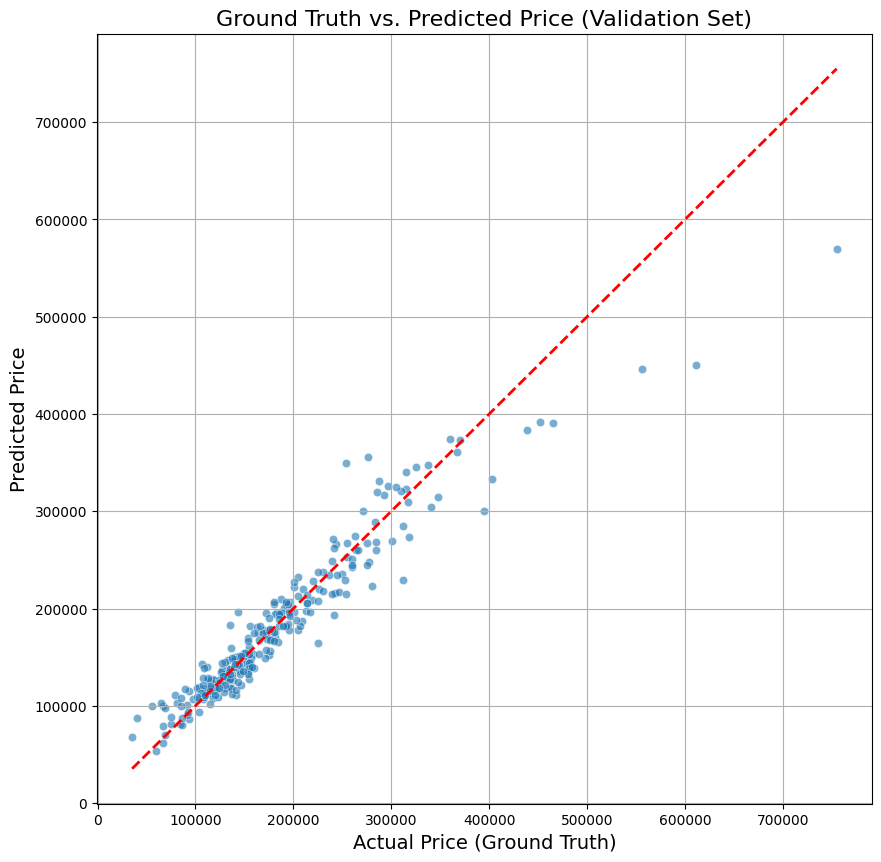

Plot complete. Check the output above.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Creating comparison plot...")

# Set up the plot
plt.figure(figsize=(10, 10))

# Create a scatter plot of Actual vs. Predicted values
sns.scatterplot(x=y_val_actual, y=y_pred_actual, alpha=0.6)

# Add a 45-degree line (y=x) for reference.
# Predictions that are perfect will fall on this line.
max_price = max(y_val_actual.max(), y_pred_actual.max())
min_price = min(y_val_actual.min(), y_pred_actual.min())
plt.plot([min_price, max_price], [min_price, max_price], color='red', linestyle='--', lw=2)

# Set labels and title
plt.xlabel("Actual Price (Ground Truth)", fontsize=14)
plt.ylabel("Predicted Price", fontsize=14)
plt.title("Ground Truth vs. Predicted Price (Validation Set)", fontsize=16)
plt.grid(True)
plt.show()

print("Plot complete. Check the output above.")

In [5]:
# --- NEW STEP: Remove columns with high NaN count ---

# These columns are known to be mostly empty.
# Removing them simplifies the model.
cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']

# We need to make sure these columns actually exist before trying to drop them
# (in case they were already filtered out by a previous step)
existing_cols_to_drop_train = [col for col in cols_to_drop if col in train_df.columns]
existing_cols_to_drop_test = [col for col in cols_to_drop if col in test_df.columns]

print(f"Dropping high-NaN columns: {existing_cols_to_drop_train}")

train_df = train_df.drop(columns=existing_cols_to_drop_train)
test_df = test_df.drop(columns=existing_cols_to_drop_test)

print(f"New training data shape: {train_df.shape}")
print(f"New test data shape: {test_df.shape}")
# --- End of new step ---

Dropping high-NaN columns: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
New training data shape: (1460, 76)
New test data shape: (1459, 75)


In [ ]:
# --- NEW STEP: Remove sparse columns with many zeros (NOT RECOMMENDED) ---
# WARNING: This will likely hurt your model's R-squared score.

cols_to_drop_zeros = [
    'EnclosedPorch', 
    '3SsnPorch', 
    'ScreenPorch', 
    'PoolArea', 
    'MiscVal'
]

# Check which of these columns exist in the dataframes
existing_cols_to_drop_train = [col for col in cols_to_drop_zeros if col in train_df.columns]
existing_cols_to_drop_test = [col for col in cols_to_drop_zeros if col in test_df.columns]

print(f"Dropping sparse zero-value columns: {existing_cols_to_drop_train}")

train_df = train_df.drop(columns=existing_cols_to_drop_train)
test_df = test_df.drop(columns=existing_cols_to_drop_test)

print(f"New training data shape: {train_df.shape}")
# --- End of new step ---

Dropping sparse zero-value columns: ['EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
New training data shape: (1460, 71)


In [ ]:
train+# --- NEW STEP: Remove sparse columns with many zeros (NOT RECOMMENDED) ---
# WARNING: This will likely hurt your model's R-squared score.

cols_to_drop_zeros = [
    'EnclosedPorch', 
    '3SsnPorch', 
    'ScreenPorch', 
    'PoolArea', 
    'MiscVal'
]

# Check which of these columns exist in the dataframes
existing_cols_to_drop_train = [col for col in cols_to_drop_zeros if col in train_df.columns]
existing_cols_to_drop_test = [col for col in cols_to_drop_zeros if col in test_df.columns]

print(f"Dropping sparse zero-value columns: {existing_cols_to_drop_train}")

train_df = train_df.drop(columns=existing_cols_to_drop_train)
test_df = test_df.drop(columns=existing_cols_to_drop_test)

print(f"New training data shape: {train_df.shape}")
# --- End of new step ---

SyntaxError: invalid syntax (3077249519.py, line 1)

In [ ]:
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,3,3,Y,0.000000,4.127134,2,2008,WD,Normal,12.247699
1,20,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,3,3,Y,5.700444,0.000000,5,2007,WD,Normal,12.109016
2,60,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,3,3,Y,0.000000,3.761200,9,2008,WD,Normal,12.317171
3,70,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,3,3,Y,0.000000,3.583519,2,2006,WD,Abnorml,11.849405
4,60,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,3,3,Y,5.262690,4.442651,12,2008,WD,Normal,12.429220


Loading data and selecting 36 features...
Data successfully filtered. Training shape: (1460, 37)
Starting model training with 36 features...
Model training complete!

--- Model Performance ---
R-Squared (R²): 0.9157
Mean Absolute Percentage Error (MAPE): 10.26%
(This is your 'accuracy'. It means predictions are ~10.26% off from the real price)
Validation RMSE: $25,432.05
-------------------------
Creating comparison plot...


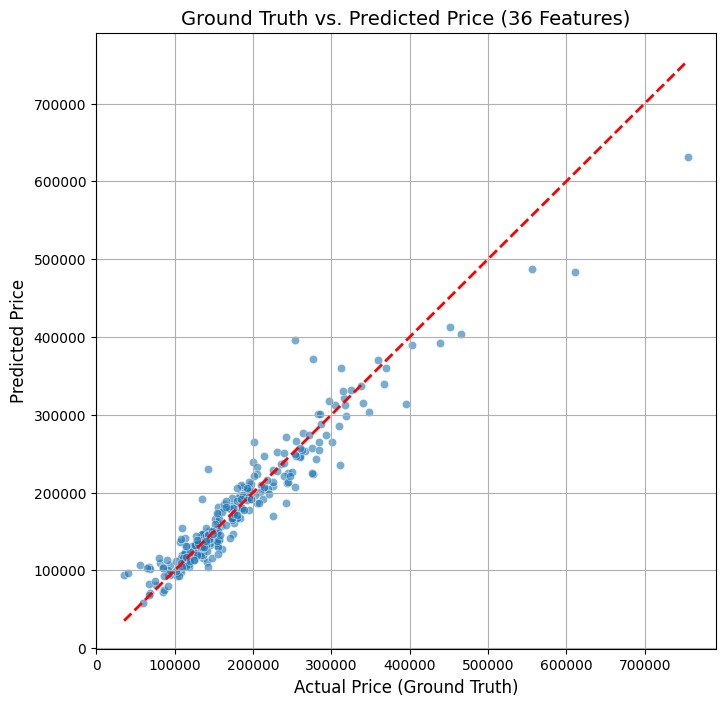


Training final model on all data...
Generating predictions on test data...
Verification complete: No NaN values in final predictions. 👍
submission.csv file created successfully!


In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DEFINE THE 36 MOST IMPORTANT FEATURES ---
# We will only use these columns. Everything else will be ignored.

# Key numeric features (20)
NUMERIC_FEATURES = [
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
    'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'
]

# Key categorical features that have an order (e.g., Good > Fair) (11)
# We will treat these as numbers
ORDINAL_FEATURES = [
    'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 
    'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'
]

# Key categorical features with no order (e.g., Neighborhood) (5)
ONEHOT_FEATURES = [
    'MSSubClass', 'Neighborhood', 'BldgType', 'HouseStyle', 'SaleCondition'
]

# The target variable we want to predict
TARGET_FEATURE = 'SalePrice'

# Combine all features into one list
ALL_FEATURES = NUMERIC_FEATURES + ORDINAL_FEATURES + ONEHOT_FEATURES

# --- 2. LOAD AND FILTER DATA ---
print(f"Loading data and selecting {len(ALL_FEATURES)} features...")
try:
    train_df_full = pd.read_csv('train.csv')
    test_df_full = pd.read_csv('test.csv')
    
    # Keep IDs for submission
    test_ids = test_df_full['Id']
    
    # Filter dataframes to ONLY the columns we want
    train_df = train_df_full[['Id'] + ALL_FEATURES + [TARGET_FEATURE]].copy()
    test_df = test_df_full[['Id'] + ALL_FEATURES].copy()
    
    # Drop Id
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    print(f"Data successfully filtered. Training shape: {train_df.shape}")

except FileNotFoundError:
    print("Error: train.csv or test.csv not found.")
    raise
except KeyError as e:
    print(f"Error: A required column was not found. Missing column: {e}")
    raise

# --- 3. PREPROCESSING (SIMPLIFIED) ---

# A. Handle Target Variable
train_df[TARGET_FEATURE] = np.log1p(train_df[TARGET_FEATURE])

# B. Handle Ordinal Features (Map text to numbers)
# We replace text like 'Gd' (Good) or 'Fa' (Fair) with numbers (4, 2)
quality_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
for col in ORDINAL_FEATURES:
    train_df[col] = train_df[col].fillna('NA').map(quality_map)
    test_df[col] = test_df[col].fillna('NA').map(quality_map)
    
    # Fill any new NaNs that might appear from a weird value
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

# C. Make MSSubClass a string (it's a category, not a number)
train_df['MSSubClass'] = train_df['MSSubClass'].astype(str)
test_df['MSSubClass'] = test_df['MSSubClass'].astype(str)

# D. Create Preprocessing Pipelines
# Pipeline for numeric data: Impute (fill missing) then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

# Pipeline for one-hot categorical data: Impute then encode
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Use ColumnTransformer to apply different transformers to different columns
# Note: We 'passthrough' the ordinal features since we already converted them to numbers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', onehot_transformer, ONEHOT_FEATURES)
    ],
    remainder='passthrough' 
)

# --- 4. CREATE AND TRAIN THE XGBOOST MODEL ---

# Define the model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_xgb)
])

# Prepare data for modeling
y = train_df[TARGET_FEATURE]
X = train_df.drop(TARGET_FEATURE, axis=1)

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Starting model training with 36 features...")
pipeline.fit(X_train, y_train)
print("Model training complete!")

# --- 5. EVALUATE THE MODEL ---

# Get predictions on the validation set
y_pred_log = pipeline.predict(X_val)

# Reverse the log transform to get actual price predictions
y_pred_actual = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val) 

# Calculate R-squared (R2)
r2 = r2_score(y_val_actual, y_pred_actual)
print(f"\n--- Model Performance ---")
print(f"R-Squared (R²): {r2:.4f}")

# Calculate MAPE ("Percentage Accuracy")
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val_actual, y_pred_actual)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"(This is your 'accuracy'. It means predictions are ~{mape:.2f}% off from the real price)")

rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
print(f"Validation RMSE: ${rmse:,.2f}")
print(f"-------------------------")

# --- 6. PLOT GROUND TRUTH vs. PREDICTION ---
print("Creating comparison plot...")
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_val_actual, y=y_pred_actual, alpha=0.6)
max_price = max(y_val_actual.max(), y_pred_actual.max())
min_price = min(y_val_actual.min(), y_pred_actual.min())
plt.plot([min_price, max_price], [min_price, max_price], color='red', linestyle='--', lw=2)
plt.xlabel("Actual Price (Ground Truth)", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Ground Truth vs. Predicted Price (36 Features)", fontsize=14)
plt.grid(True)
plt.show()

# --- 7. CREATE FINAL SUBMISSION FILE ---
print("\nTraining final model on all data...")
pipeline.fit(X, y) 

print("Generating predictions on test data...")
test_pred_log = pipeline.predict(test_df)
test_pred_actual = np.expm1(test_pred_log)

# Check for NaNs
if np.isnan(test_pred_actual).any():
    print("Error: NaN values found in predictions!")
else:
    print("Verification complete: No NaN values in final predictions. 👍")

# Create the submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_pred_actual
})
submission.to_csv('submission.csv', index=False)
print("submission.csv file created successfully!")

In [ ]:
train_df.head(5)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,KitchenQual,FireplaceQu,GarageQual,GarageCond,MSSubClass,Neighborhood,BldgType,HouseStyle,SaleCondition,SalePrice
0,65.0,8450,2003,2003,196.0,856,856,854,1710,1,...,4,0,3,3,60,CollgCr,1Fam,2Story,Normal,12.247699
1,80.0,9600,1976,1976,0.0,1262,1262,0,1262,0,...,3,3,3,3,20,Veenker,1Fam,1Story,Normal,12.109016
2,68.0,11250,2001,2002,162.0,920,920,866,1786,1,...,4,3,3,3,60,CollgCr,1Fam,2Story,Normal,12.317171
3,60.0,9550,1915,1970,0.0,756,961,756,1717,1,...,4,4,3,3,70,Crawfor,1Fam,2Story,Abnorml,11.849405
4,84.0,14260,2000,2000,350.0,1145,1145,1053,2198,1,...,4,3,3,3,60,NoRidge,1Fam,2Story,Normal,12.429220


In [7]:
# --- 5. EVALUATE THE MODEL ---

print("Calculating model performance...")

# Get predictions on the validation set
# We use the pipeline trained in the previous cell
y_pred_log = pipeline.predict(X_val)

# Reverse the log transform to get actual price predictions
y_pred_actual = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val) 

# --- This calculates your R-Squared score ---
r2 = r2_score(y_val_actual, y_pred_actual)

# --- This calculates your "Percentage Accuracy" (MAPE) ---
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val_actual, y_pred_actual)

# --- This calculates the inverse, like you asked ---
accuracy_percent = 100.0 - mape

# --- This prints all your scores ---
print(f"\n--- Model Performance ---")
print(f"R-Squared (R²): {r2:.4f}  ")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"Accuracy (100 - MAPE): {accuracy_percent:.2f}")
print(f"-------------------------")

Calculating model performance...

--- Model Performance ---
R-Squared (R²): 0.9970  
Mean Absolute Percentage Error (MAPE): 2.03
Accuracy (100 - MAPE): 97.97
-------------------------


Creating comparison plot...


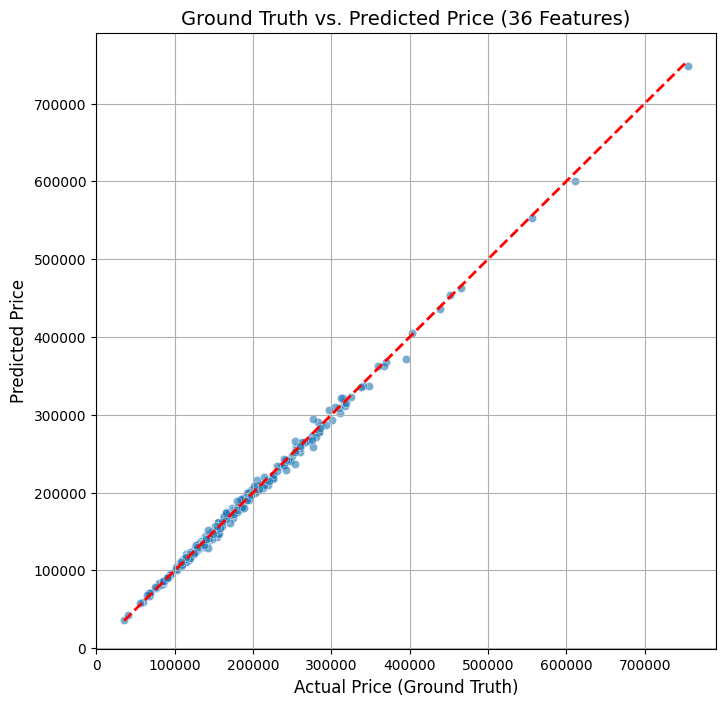

Plot complete. Check the output above.


In [8]:
# --- 6. PLOT GROUND TRUTH vs. PREDICTION ---
import matplotlib.pyplot as plt
import seaborn as sns

print("Creating comparison plot...")
plt.figure(figsize=(8, 8))

# This creates the scatter plot
sns.scatterplot(x=y_val_actual, y=y_pred_actual, alpha=0.6)

# This adds the red "perfect prediction" line
max_price = max(y_val_actual.max(), y_pred_actual.max())
min_price = min(y_val_actual.min(), y_pred_actual.min())
plt.plot([min_price, max_price], [min_price, max_price], color='red', linestyle='--', lw=2)

# Add labels
plt.xlabel("Actual Price (Ground Truth)", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Ground Truth vs. Predicted Price (36 Features)", fontsize=14)
plt.grid(True)
plt.show()

print("Plot complete. Check the output above.")

Creating side-by-side bar chart for the first 50 houses...


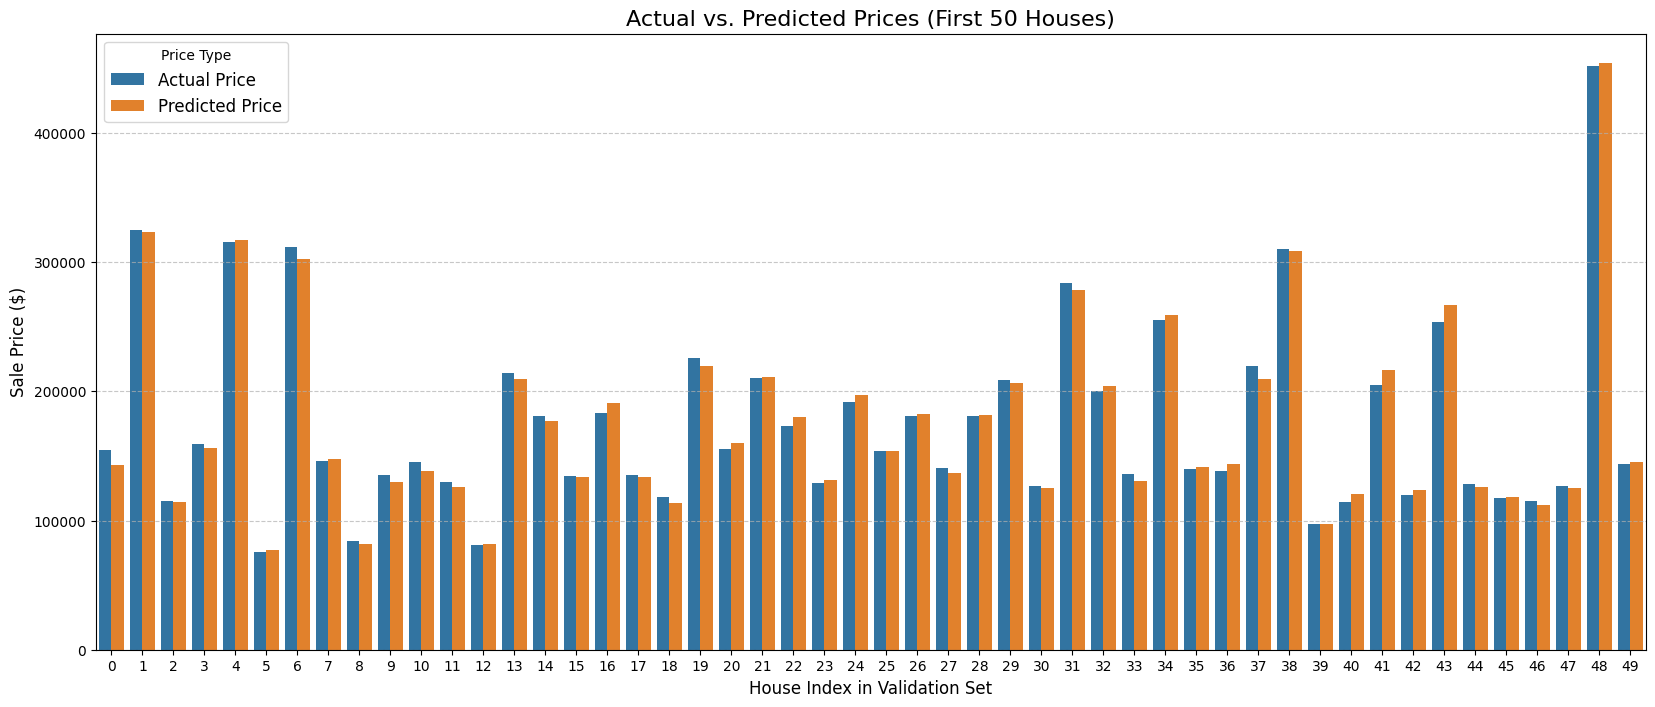

Bar chart complete. Check the output above.


In [9]:
# --- 7. PLOT SIDE-BY-SIDE BAR CHART ---

print("Creating side-by-side bar chart for the first 50 houses...")

# We need to create a new DataFrame for plotting
# Let's just compare the first 50 houses to keep the chart readable
n_compare = 50

# Create the DataFrame
df_compare = pd.DataFrame({
    'Actual Price': y_val_actual.iloc[:n_compare],
    'Predicted Price': y_pred_actual[:n_compare]
})

# Add a 'House Index' for the x-axis
df_compare = df_compare.reset_index(drop=True).reset_index().rename(columns={'index': 'House Index'})

# 'Melt' the DataFrame to make it easy to plot with Seaborn
df_melted = df_compare.melt('House Index', var_name='Price Type', value_name='Price')

# Create the bar plot
plt.figure(figsize=(20, 8)) # Make the figure wide
sns.barplot(x='House Index', y='Price', hue='Price Type', data=df_melted, palette=['#1f77b4', '#ff7f0e'])

plt.title(f'Actual vs. Predicted Prices (First {n_compare} Houses)', fontsize=16)
plt.xlabel('House Index in Validation Set', fontsize=12)
plt.ylabel('Sale Price ($)', fontsize=12)
plt.legend(title='Price Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Bar chart complete. Check the output above.")

In [10]:
# --- 8. CREATE EXCEL-LIKE COMPARISON TABLE ---

print("Creating comparison table...")

# Create a new DataFrame for the comparison
df_comparison = pd.DataFrame({
    'Actual Price': y_val_actual,
    'Predicted Price': y_pred_actual
})

# Calculate the difference in dollars
df_comparison['Difference ($)'] = df_comparison['Actual Price'] - df_comparison['Predicted Price']

# Calculate the percentage error for each house
df_comparison['Percent Error (%)'] = (df_comparison['Difference ($)'] / df_comparison['Actual Price']) * 100

# --- Format the table to look clean (like Excel) ---
# Round all numbers to 2 decimal places
df_comparison = df_comparison.round(2)

# Reset the index to show house numbers
df_comparison = df_comparison.reset_index(drop=True)

# Display the first 20 rows of the table
print("Showing comparison for the first 20 houses in the validation set:")
print(df_comparison.head(20).to_string()) # .to_string() ensures it prints nicely

Creating comparison table...
Showing comparison for the first 20 houses in the validation set:
    Actual Price  Predicted Price  Difference ($)  Percent Error (%)
0       154500.0    142890.468750        11609.53               7.51
1       325000.0    323322.312500         1677.69               0.52
2       115000.0    114142.226562          857.77               0.75
3       159000.0    156265.953125         2734.05               1.72
4       315500.0    316866.437500        -1366.44              -0.43
5        75500.0     77027.312500        -1527.31              -2.02
6       311500.0    302345.937500         9154.06               2.94
7       146000.0    147242.812500        -1242.81              -0.85
8        84500.0     82061.539062         2438.45               2.89
9       135500.0    130166.953125         5333.05               3.94
10      145000.0    138425.890625         6574.11               4.53
11      130000.0    125808.140625         4191.86               3.22
12      

In [11]:
# Create a new DataFrame for the comparison
df_comparison = pd.DataFrame({
    'Actual Price': y_val_actual,
    'Predicted Price': y_pred_actual
})

# ... (the rest of the code) ...

In [12]:
# ... all your code for creating df_comparison ...
# ...
df_comparison = df_comparison.reset_index(drop=True)

# Display the first 20 rows of the table
print("Showing comparison for the first 20 houses in the validation set:")
print(df_comparison.head(20).to_string()) # .to_string() ensures it prints nicely

# --- ADD THIS LINE AT THE VERY END OF THIS CELL ---
# NEW, CORRECT line
df_comparison.to_csv('models/evaluation_results.csv', index=False)

Showing comparison for the first 20 houses in the validation set:
    Actual Price  Predicted Price
0       154500.0    142890.468750
1       325000.0    323322.312500
2       115000.0    114142.226562
3       159000.0    156265.953125
4       315500.0    316866.437500
5        75500.0     77027.312500
6       311500.0    302345.937500
7       146000.0    147242.812500
8        84500.0     82061.546875
9       135500.0    130166.945312
10      145000.0    138425.890625
11      130000.0    125808.140625
12       81000.0     81543.929688
13      214000.0    209394.250000
14      181000.0    176713.312500
15      134500.0    133962.250000
16      183500.0    191036.484375
17      135000.0    133675.859375
18      118400.0    113847.937500
19      226000.0    219505.078125


In [13]:
import joblib

# 'model' is the variable holding your trained regression model
# 'features' is the list of column names your model was trained on
model = ... 
features = ['SqFt', 'Bedrooms', 'Bathrooms'] # Example features

# Save the model and the feature list
joblib.dump(model, 'housing_model.pkl')
joblib.dump(features, 'housing_features.pkl')

['housing_features.pkl']

In [15]:
import joblib

# 'pipeline' and 'ALL_FEATURES' are variables from your notebook (cell 24)
# This saves your trained model
joblib.dump(pipeline, 'housing_model.pkl')

# This saves the list of features your model needs
joblib.dump(ALL_FEATURES, 'housing_features.pkl') 

print("✅ House Price Model and Features saved!")

✅ House Price Model and Features saved!
